# Data Science Group project 1, Energy consumption Helsinki

## ML6, Integrify

### Ann Ha & Hannu Kiiskinen, 25.11.2023

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
from dash import Dash, dcc, html, Input, Output, callback
import plotly.express as px

## Descriptive statistics

### Dataset

Nuuka open API, which provides energy consumption information for the City of Helsinki’s service properties, is a channel through which the user can search for information about properties owned by the City of Helsinki and their energy consumption.

As the latest Data is more accurate, we used data of year 2022.

We selected six different type of buildings and their electricity use:
- School
- Health Caring Center
- Library
- Dockyard
- Museum
- Office building

In [2]:
# Load the property information
properties = pd.read_json("DS_GroupProject1/response_1701339825620.json")
properties1 = pd.read_json("DS_GroupProject1/response_1701340050130.json")
properties = properties.append(properties1, ignore_index=True)
properties2 = pd.read_json("DS_GroupProject1/response_1701341030721.json")
properties = properties.append(properties2, ignore_index=True)
properties3 = pd.read_json("DS_GroupProject1/response_1701341245058.json")
properties = properties.append(properties3, ignore_index=True)
properties4 = pd.read_json("DS_GroupProject1/response_1701341298278.json")
properties = properties.append(properties4, ignore_index=True)
properties5 = pd.read_json("DS_GroupProject1/response_1701341342744.json")
properties = properties.append(properties5, ignore_index=True)
properties_list = properties.filter(items=['propertyName', 'yearOfIntroduction', 'purposeOfUse', 'totalArea', 'heatedArea',
                                           'volume', 'buildingType'])
# Remove the time
properties_list['yearOfIntroduction'] = pd.to_datetime(properties_list['yearOfIntroduction'])
properties_list['yearOfIntroduction'] = properties_list['yearOfIntroduction'].dt.floor('d')
properties_list['yearOfIntroduction'] = properties_list['yearOfIntroduction'].dt.normalize()
properties_list

,propertyName,yearOfIntroduction,purposeOfUse,totalArea,heatedArea,volume,buildingType
0,1528 Apollon yhteiskoulu,1985-01-01,H ala-aste ja yläaste,5510,3859.0,26900,EducationalInstitution
1,1561 Työterveyskeskus,1941-01-01,D toimisto,8621,5804.0,32393,HealthCare_HealthCenter
2,1598 Jakomäen kirjasto,1981-01-01,G kirjasto,489,424.0,2000,LibraryMuseumExhibitionHall
3,1680 Vuosaaren telakka,1974-01-01,D toimisto,3300,2544.7,19630,VocationalEducationalInstitution
4,1715 Raitiovaunumuseo,1900-01-01,G museo,1774,1436.0,9559,LibraryMuseumExhibitionHall
5,1716 Töölön virastotalo,1965-01-01,D toimisto,7850,5790.0,28464,Office


Apollon elementary School, Health caring center, Jakomäki library

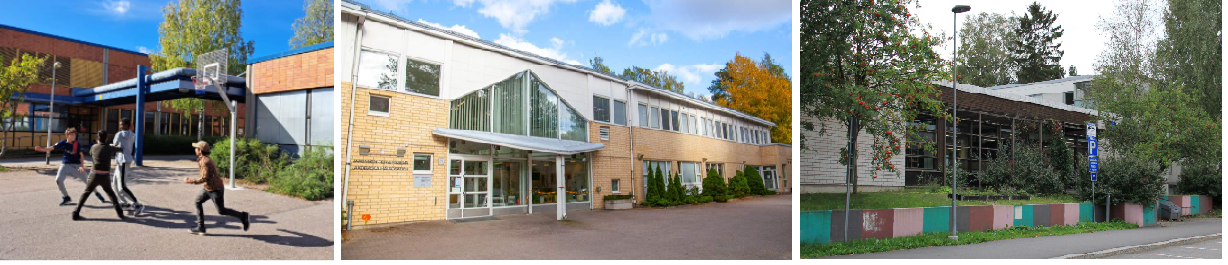

Vuosaari Dockyard, Tram museum, Töölö office building

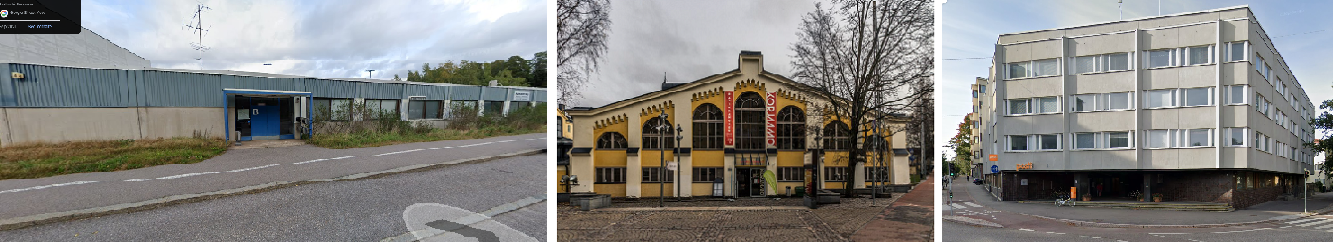

Industrial action ended in Vuosaari Dockyard 2016, now there are located Vocational Educational Institution

In [3]:
# Loading the data of Buildings
df1561 = pd.read_json("DS_GroupProject1/response_1700916222795.json")
df1528 = pd.read_json("DS_GroupProject1/response_1700916276359.json")
df1598 = pd.read_json("DS_GroupProject1/response_1700916312042.json")
df1680 = pd.read_json("DS_GroupProject1/response_1700916346194.json")
df1715 = pd.read_json("DS_GroupProject1/response_1700916377431.json")
df1716 = pd.read_json("DS_GroupProject1/response_1700916413922.json")

In [4]:
# Merge data in one dataframe
df_merged1 = pd.merge(df1561, df1528, on=['timestamp',  'reportingGroup', 'unit'])
df_merged2 = pd.merge(df1598, df1680, on=['timestamp',  'reportingGroup', 'unit'])
df_merged3 = pd.merge(df1715, df1716, on=['timestamp',  'reportingGroup', 'unit'])
df_merged = pd.merge(df_merged1, df_merged2, on=['timestamp',  'reportingGroup', 'unit'])
df_merged = pd.merge(df_merged, df_merged3, on=['timestamp',  'reportingGroup', 'unit'])
df_merged = df_merged.rename(columns={'value_x_x': '1561-HealthCC', 'value_y_x': '1528-School', 'value_x_y': '1598-Library',
                                      'value_y_y': '1680-Dockyard', 'value_x': '1715-Museum', 'value_y': '1716-Office'})
df_merged.head(5)

,timestamp,reportingGroup,locationName_x_x,1561-HealthCC,unit,locationName_y_x,1528-School,locationName_x_y,1598-Library,locationName_y_y,1680-Dockyard,locationName_x,1715-Museum,locationName_y,1716-Office
0,2022-01-01 00:00:00,Electricity,1561 Työterveyskeskus,26.84,kWh,1528 Apollon yhteiskoulu,16.08,1598 Jakomäen kirjasto,3.47,1680 Vuosaaren telakka (disabled),39.76,1715 Raitiovaunumuseo,32.65,1716 Töölön virastotalo,43.36
1,2022-01-01 01:00:00,Electricity,1561 Työterveyskeskus,26.96,kWh,1528 Apollon yhteiskoulu,16.24,1598 Jakomäen kirjasto,3.39,1680 Vuosaaren telakka (disabled),39.79,1715 Raitiovaunumuseo,32.50,1716 Töölön virastotalo,43.60
2,2022-01-01 02:00:00,Electricity,1561 Työterveyskeskus,27.32,kWh,1528 Apollon yhteiskoulu,16.24,1598 Jakomäen kirjasto,3.39,1680 Vuosaaren telakka (disabled),39.25,1715 Raitiovaunumuseo,33.06,1716 Töölön virastotalo,43.52
3,2022-01-01 03:00:00,Electricity,1561 Työterveyskeskus,26.96,kWh,1528 Apollon yhteiskoulu,16.32,1598 Jakomäen kirjasto,3.39,1680 Vuosaaren telakka (disabled),39.14,1715 Raitiovaunumuseo,33.06,1716 Töölön virastotalo,43.68
4,2022-01-01 04:00:00,Electricity,1561 Työterveyskeskus,26.92,kWh,1528 Apollon yhteiskoulu,16.32,1598 Jakomäen kirjasto,3.61,1680 Vuosaaren telakka (disabled),39.30,1715 Raitiovaunumuseo,32.99,1716 Töölön virastotalo,43.60


In [5]:
# Drop unnecessary columns from Merged DataFrame
df_merged = df_merged.drop('reportingGroup', axis=1)
df_merged = df_merged.drop('locationName_x_x', axis=1)
df_merged = df_merged.drop('unit', axis=1)
df_merged = df_merged.drop('locationName_y_x', axis=1)
df_merged = df_merged.drop('locationName_x_y', axis=1)
df_merged = df_merged.drop('locationName_y_y', axis=1)
df_merged = df_merged.drop('locationName_x', axis=1)
df_merged = df_merged.drop('locationName_y', axis=1)
df_merged

,timestamp,1561-HealthCC,1528-School,1598-Library,1680-Dockyard,1715-Museum,1716-Office
0,2022-01-01 00:00:00,26.84,16.08,3.47,39.76,32.65,43.36
1,2022-01-01 01:00:00,26.96,16.24,3.39,39.79,32.50,43.60
2,2022-01-01 02:00:00,27.32,16.24,3.39,39.25,33.06,43.52
3,2022-01-01 03:00:00,26.96,16.32,3.39,39.14,33.06,43.68
4,2022-01-01 04:00:00,26.92,16.32,3.61,39.30,32.99,43.60
...,...,...,...,...,...,...,...
8616,2022-12-31 20:00:00,39.75,10.56,3.47,45.71,28.67,43.92
8617,2022-12-31 21:00:00,39.76,10.40,3.54,45.53,28.98,43.28
8618,2022-12-31 22:00:00,39.81,10.48,3.50,44.96,29.41,40.08
8619,2022-12-31 23:00:00,39.81,10.48,3.46,45.14,29.71,39.76


## Data review

8621 entries, 7 columns.

One field as datetime, six fields as float.

In [6]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 0 to 8620
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      8621 non-null   datetime64[ns]
 1   1561-HealthCC  8621 non-null   float64       
 2   1528-School    8621 non-null   float64       
 3   1598-Library   8621 non-null   float64       
 4   1680-Dockyard  8621 non-null   float64       
 5   1715-Museum    8621 non-null   float64       
 6   1716-Office    8621 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 538.8 KB


### Distribution of data

In [7]:
df_merged.describe()

,1561-HealthCC,1528-School,1598-Library,1680-Dockyard,1715-Museum,1716-Office
count,8621.000000,8621.000000,8621.000000,8621.000000,8621.000000,8621.000000
mean,50.569305,10.521202,4.698222,41.850815,20.205482,46.550525
std,22.128564,5.216545,2.186591,13.427506,8.973073,7.715456
min,21.000000,0.000000,0.000000,21.880000,0.000000,31.600000
25%,32.480000,4.800000,3.090000,31.430000,13.710000,41.120000
50%,44.800000,12.320000,3.450000,38.520000,17.840000,43.600000
75%,65.160000,15.040000,7.060000,51.040000,24.930000,50.880000
max,290.400000,35.840000,24.390000,101.720000,94.600000,124.800000


### Factors (meaning of the columns)

- timestamp, one year period measurement every hour
- location numbers (6 buildings), energy consumption measured on given timestamp

### Relationships between features

#### Relationship between different Building will be shown in Plotly Dash.

In [8]:
app = Dash(__name__)

df1 = df_merged

app.layout = html.Div(children=[
#    html.H3(children='Ecommerce Dataset'),

    html.Label("Select the Building"),
    dcc.Dropdown(
        id='target-variable',
        options=[{'label': col, 'value': col} for col in df_merged.columns[1:]],
        value=df_merged.columns[1]
    ),
    # Radio buttons for selecting visualization type
    html.Label("Select the timeline"),
    dcc.RadioItems(
        id='visualization-type',
        options=[
            {'label': 'Full Year', 'value': 'Full'},
            {'label': 'First Third', 'value': 'First Third'},
            {'label': 'Second Third', 'value': 'Second Third'},
            {'label': 'Last Third', 'value': 'Last Third'},
            {'label': 'First Month', 'value': 'First Month'},
            {'label': 'Second Week', 'value': 'Second Week'},
            {'label': 'Second Monday', 'value': 'Second Monday'}
        ],
        value='Full',
        labelStyle={'display': 'block'}
    ),
    # Graph container
    dcc.Graph(id='graph')
])
# Callback to update the graph based on user input
@app.callback(
    Output('graph', 'figure'),
    [Input('target-variable', 'value'),
     Input('visualization-type', 'value')]
)
def update_graph(target_var, vis_type):
    if vis_type == 'Full':
        df1 = df_merged
    elif vis_type == 'First Third':
        cut1 = (len(df_merged) / 3)
        df1 = df_merged.loc[0 : cut1]
    elif vis_type == 'Second Third':
        cut1 = (len(df_merged) / 3)
        cut2 = (cut1*2)
        df1 = df_merged.loc[cut1 : cut2]
    elif vis_type == 'First Month':
        cut1 = (len(df_merged) / 12)
        df1 = df_merged.loc[0 : cut1]
    elif vis_type == 'Second Week':
        cut1 = (24 * 9)
        cut2 = (24 * 16)
        df1 = df_merged.loc[cut1 : cut2]
    elif vis_type == 'Second Monday':
        cut1 = (24 * 9)
        cut2 = (24 * 10)
        df1 = df_merged.loc[cut1 : cut2]
    else:
        cut1 = (len(df_merged) / 3)
        cut1 = (cut1*2)
        df1 = df_merged.loc[cut1 : ]
    fig = px.line(df1, x='timestamp', y=target_var)
    return fig

if __name__ == '__main__':
    app.run(debug=True)

## Explotary Data Analysis

- time series data, measurement every hours

Checking also the continuous Factors:
- all Buildings having outliers (as was seen the spikes in plot)

<AxesSubplot:>

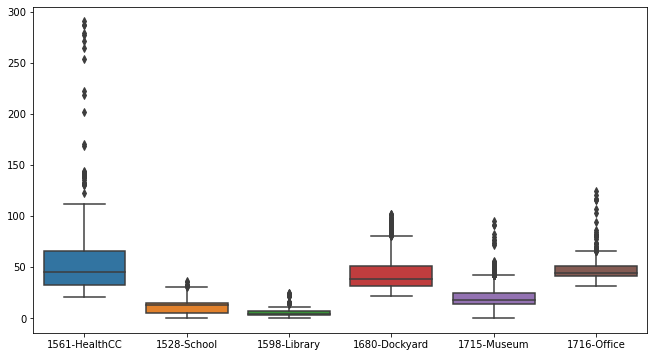

In [10]:
# BoxPlot to show ourliers
plt.figure(figsize=(11, 6))
sns.boxplot(data=df_merged)

In [11]:
# Test the normality of 1561-HealthCC (just in case)
df1 = df_merged.filter(items=['1561-HealthCC'])
alpha = 0.05
_, p_value = stats.shapiro(df1)
if p_value < alpha:
    print('1561-HealthCC is not normally distributed')
else:
    print('1561-HealthCC is normally distributed')

1561-HealthCC is not normally distributed


C:\Users\Hannu\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning:

p-value may not be accurate for N > 5000.



### Clean the data

- No errors, dublicates or missing values

### Transformation

- Datetime transformation needed to evaluate more what happens in the school data

In [69]:
df_eval = df_merged.filter(items=['1528-School', '1598-Library', '1715-Museum', 'timestamp'])
df_eval['Day'] = [d.date() for d in df_eval['timestamp']]
df_eval['Time'] = [d.time() for d in df_eval['timestamp']]
df_eval.head()

,1528-School,1598-Library,1715-Museum,timestamp,Day,Time
0,16.08,3.47,32.65,2022-01-01 00:00:00,2022-01-01,00:00:00
1,16.24,3.39,32.50,2022-01-01 01:00:00,2022-01-01,01:00:00
2,16.24,3.39,33.06,2022-01-01 02:00:00,2022-01-01,02:00:00
3,16.32,3.39,33.06,2022-01-01 03:00:00,2022-01-01,03:00:00
4,16.32,3.61,32.99,2022-01-01 04:00:00,2022-01-01,04:00:00


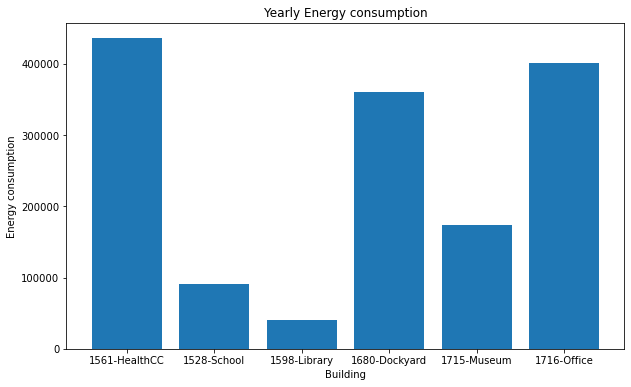

In [13]:
# Define the categories and their values
categories = df_merged.columns[1:]
values = df_merged.sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, values)

# Add labels and a title
plt.xlabel('Building')
plt.ylabel('Energy consumption')
plt.title('Yearly Energy consumption')

# Show the plot
plt.show()

### Exceptional data

Text(0.5, 1.0, 'Energy consumption Spikes')

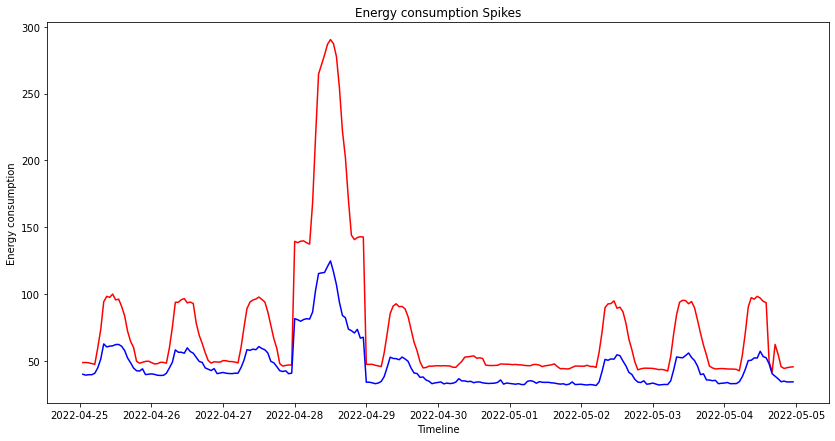

In [51]:
# Plot the Energy consumption Spikes in timeline
df_draw = df_merged.filter(items=['1561-HealthCC', '1716-Office', 'timestamp'])
df_draw = df_draw[(df_draw['timestamp'] > '2022-04-25 00:00:00') & (df_draw['timestamp'] < '2022-05-05 00:00:00')]
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_draw, x="timestamp", y="1561-HealthCC", color='red')
sns.lineplot(data=df_draw, x="timestamp", y="1716-Office", color='blue')

# Add labels and a title
plt.xlabel('Timeline')
plt.ylabel('Energy consumption')
plt.title('Energy consumption Spikes')

28.4.2022 Spike, more than double Energy consumption in one day, what happened?
- error is measurement
- Tappara won the Finnish championship in ice hockey

Text(0.5, 1.0, 'Exceptional Energy consumption in School')

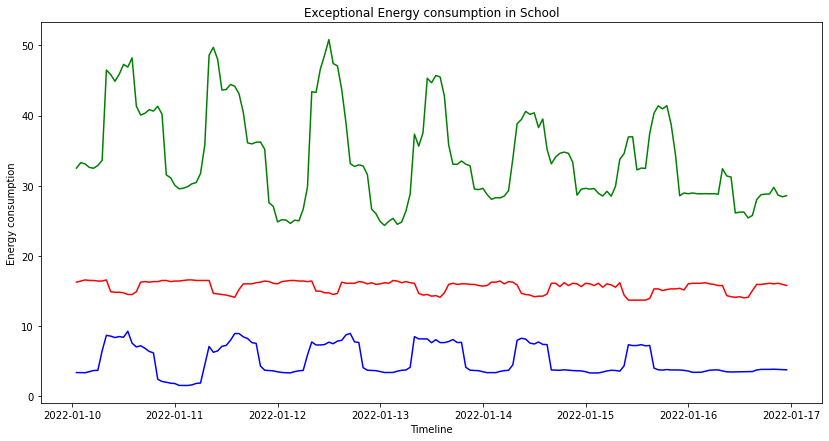

In [48]:
# Plot the Energy consumption in School in timeline
df_draw = df_merged.filter(items=['1528-School', '1598-Library', '1715-Museum', 'timestamp'])
df_draw = df_draw[(df_draw['timestamp'] > '2022-01-10 00:00:00') & (df_draw['timestamp'] < '2022-01-17 00:00:00')]
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_draw, x="timestamp", y="1528-School", color='red')
sns.lineplot(data=df_draw, x="timestamp", y="1598-Library", color='blue')
sns.lineplot(data=df_draw, x="timestamp", y="1715-Museum", color='green')

# Add labels and a title
plt.xlabel('Timeline')
plt.ylabel('Energy consumption')
plt.title('Exceptional Energy consumption in School')

Energy consumption in <font color='red'>School</font> is opposite compared to <font color='blue'>Library</font> or <font color='green'>Museum</font>, when power consumption goes up in Library and Museum, it goes down in School and vice versa. Could it be that clock settings in School measurement device are shifted 12 hours?

In [70]:
df_eval_School = df_eval[df_eval['1528-School'] == 0][['1528-School', 'Day', 'Time']]
df_eval_School

,1528-School,Day,Time
3601,0.0,2022-06-01,02:00:00
3602,0.0,2022-06-01,03:00:00
3603,0.0,2022-06-01,04:00:00


In [71]:
df_eval_Museum = df_eval[df_eval['1715-Museum'] == 0][['1715-Museum', 'Day', 'Time']]
df_eval_Museum

,1715-Museum,Day,Time
3690,0.0,2022-06-04,19:00:00
3691,0.0,2022-06-04,20:00:00
3692,0.0,2022-06-04,21:00:00


In [72]:
df_eval_Library = df_eval[df_eval['1598-Library'] == 0][['1598-Library', 'Day', 'Time']]
df_eval_Library

,1598-Library,Day,Time
2545,0.0,2022-04-17,02:00:00
2546,0.0,2022-04-17,03:00:00
7757,0.0,2022-11-26,01:00:00
7758,0.0,2022-11-26,02:00:00


There are short 2-3 hour periods when the electricity have been switched totally of in these three Buildings.

## Research question 1

### Is there a relationship between Energy consumptions and different Buildings?

#### Hypothesis definition

H0: There are significant association between Energy consumptions and different Buildings

H1: There are no significant association between Energy consumptions and different Buildings

### Test selection

Numeric values, so Anova-test will be used.

In [26]:
# Using Anova-test do test between different Buildings
F_Stat, p_value = stats.f_oneway(df_merged['1561-HealthCC'], df_merged['1716-Office'], df_merged['1680-Dockyard'], 
                                df_merged['1715-Museum'], df_merged['1528-School'], df_merged['1598-Library'])
F_Stat = round(F_Stat, 1)
p_value = round(p_value, 3)

# interpret p-value
alpha = 0.05

print(f'\nF_statistics: {F_Stat}, P_value: {p_value}, alpha: {alpha}\n')

if p_value < alpha:
    print('Reject H0, There is at-least one Building which has different mean!')
else:
    print('Accept H0, all the Buildings have equal means!')


F_statistics: 23930.8, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Building which has different mean!


In [31]:
# Using Anova-test do test between two different Buildings
F_Stat, p_value = stats.f_oneway(df_merged['1715-Museum'], df_merged['1528-School'])
F_Stat = round(F_Stat, 1)
p_value = round(p_value, 3)

# interpret p-value
alpha = 0.05

print(f'\nF_statistics: {F_Stat}, P_value: {p_value}, alpha: {alpha}\n')

if p_value < alpha:
    print('Reject H0, There is at-least one Building which has different mean!')
else:
    print('Accept H0, all the Buildings have equal means!')


F_statistics: 7505.2, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Building which has different mean!


### Result of the test

As test will show, there is at-least in one Building where the Energy consumption mean is different!.

## Research question 2

### Is there a relationship between Energy consumption and different Quartiles of Year?

#### Hypothesis definition

H0: There are significant association between Energy consumptions and different Quartiles

H1: There are no significant association between Energy consumptions and different Quartiles

In [36]:
# Data split to quartiles
df1 = df_merged[(df_merged['timestamp'] > '2022-01-01 00:00:00') & (df_merged['timestamp'] < '2022-03-31 00:00:00')]
df2 = df_merged[(df_merged['timestamp'] > '2022-04-01 00:00:00') & (df_merged['timestamp'] < '2022-06-30 00:00:00')]
df3 = df_merged[(df_merged['timestamp'] > '2022-07-01 00:00:00') & (df_merged['timestamp'] < '2022-09-30 00:00:00')]
df4 = df_merged[(df_merged['timestamp'] > '2022-10-01 00:00:00')]
df1.shape, df2.shape, df3.shape, df4.shape

((2134, 7), (2043, 7), (2160, 7), (2208, 7))

In [37]:
def Test_Quartile(Building):
    # Using Anova-test do test between different Quartiles
    print(f'\nBuilding = {Building}')
    F_Stat, p_value = stats.f_oneway(df1[[Building]][Building], df2[[Building]][Building], df3[[Building]][Building], 
                                     df4[[Building]][Building])
    F_Stat = round(F_Stat, 1)
    p_value = round(p_value, 3)

    # interpret p-value
    alpha = 0.05

    print(f'\nF_statistics: {F_Stat}, P_value: {p_value}, alpha: {alpha}\n')

    if p_value < alpha:
        print('Reject H0, There is at-least one Quartile which has different mean!')
    else:
        print('Accept H0, all the Quartile have equal means!')

In [38]:
Test_Quartile('1561-HealthCC')


Building = 1561-HealthCC

F_statistics: 156.5, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Quartile which has different mean!


In [39]:
Test_Quartile('1716-Office')


Building = 1716-Office

F_statistics: 65.2, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Quartile which has different mean!


In [40]:
Test_Quartile('1680-Dockyard')


Building = 1680-Dockyard

F_statistics: 816.0, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Quartile which has different mean!


In [41]:
Test_Quartile('1715-Museum')


Building = 1715-Museum

F_statistics: 298.8, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Quartile which has different mean!


In [42]:
Test_Quartile('1528-School')


Building = 1528-School

F_statistics: 4327.7, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Quartile which has different mean!


In [43]:
Test_Quartile('1598-Library')


Building = 1598-Library

F_statistics: 7.5, P_value: 0.0, alpha: 0.05

Reject H0, There is at-least one Quartile which has different mean!


### Result of the test

As tests will show, there is at-least in one Quartile in each Building where the Energy consumption mean is different!.